# 토픽모델링
- '정의' 키워드를 제목/본문에 포함하는 글을 대상으로 토픽 모델링을 진행하는 코드다.

## 1. 모듈 임포트/함수 정의

In [1]:
from gensim import corpora
from gensim import models
from collections import defaultdict
#pip install pyLDAvis
import pyLDAvis.gensim as gensimvis
import pyLDAvis

def get_filtered_words(docs):
    term_fre_dict = defaultdict(int)
    doc_fre_dict = defaultdict(int)
    
    for doc in docs:
        for word in doc:
            term_fre_dict[word] += 1
        for word in set(doc):
            doc_fre_dict[word] += 1
    
    max_doc_frequency = 1000
    min_doc_frequency = 3
    max_term_frequency = 7000
    min_term_frequency = 5
    
    doc_frequency_filtered = {k:v for k, v in doc_fre_dict.items() if ((v>=min_doc_frequency) and (v <= max_doc_frequency))}
    term_frequency_filtered = {k:v for k, v in term_fre_dict.items() if ((v>=min_term_frequency) and (v <= max_term_frequency))}
    both_satisfied = {k:v for k, v in term_frequency_filtered.items() if k in doc_frequency_filtered}
    
    return both_satisfied

def get_highest_topic(topic_list):
    highest_topic = 100
    highest_prob = 0
    for topic, prob in topic_list:
        if prob > highest_prob:
            highest_prob = prob
            highest_topic = topic
    return highest_topic, highest_prob

def build_doc_word_matrix(docs):
    dictionary = corpora.Dictionary(docs)
    corpus = []
    for doc in docs:
        bow = dictionary.doc2bow(doc)
        corpus.append(bow)

    return corpus, dictionary

def print_topic_words(model):
    f = open(f'{KEYWORD}_LDA_.txt','w')
    for topic_id in range(model.num_topics):
        word_probs = model.show_topic(topic_id, NUM_TOPIC_WORDS)
        print("Topic ID: {}".format(topic_id))
        f.write(str(topic_id)+'\n')
        for word, prob in word_probs:
            print("\t{}\t{}".format(word, prob))
            f.write(str(word)+'\t'+str(prob)+'\n')
        print("\n")
    f.close()

## 2. 키워드 필터링 및 변수 포맷팅
- 키워드(KEYWORD)를 지정해준다.
- 불용어(stop_words)도 지정해준다.

In [40]:
#키워드 및 불용어 지정
KEYWORD = '정의'
stop_words = [KEYWORD, '국민', '대한민국', '한국', '정부', '대통령', '문재인', '사회', '사람', '문제', '청원', '모든', '대한', '지금', '현재', '나라', '국가', '우리', '저희', '관련', '생각', '까지', '면서', '부터', '대해', '때문', '위해', '대로', '이나', '해주', '도록', '이상', '정말', '내용', '당하', '아무', '보고', '래서', '더니', '려면', '고하', '처럼', '또한']

#필터 적용하여 파일 읽어오기
with open('NOUN_수정.txt', 'r', encoding='utf-8') as f:
    total_docs = [x.split(',')[-1].strip() for x in f.readlines() if KEYWORD in x.split(',')[4]]
    
#변수 포맷팅(모델링에 적합하게 변수 형태 바꾸기)
docs_nouns = [x.split(' ') for x in total_docs]

docs_filtered = [[term for term in doc if term not in stop_words and len(term)>1] for doc in docs_nouns]

article_indexes = [k for k in range(len(docs_filtered))]

corpus, dictionary = build_doc_word_matrix(docs_filtered)
# corpus = dtm based on frequency

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 45019
Number of documents: 12286


## 3. Optimal 토픽 수 구하기: Log perplexity 방법
- log perplexity 값이 **낮을수록** 정확한 분류다.
    - start1: 최소 토픽 수
    - limit1: 최대 토픽 수
    - step1: 계산할 간격

In [ ]:
#log perplexity 계산
start1 = 2         #최소 토픽 수
limit1 = 40        #최대 토픽 수
step1 = 6          #계산할 간격
perplexity_scores=[]
for num_topics in range(start1, limit1, step1):
    model = models.ldamodel.LdaModel(corpus, num_topics=num_topics,
                    id2word=dictionary,
                    alpha='auto')
    perplexity_scores.append(lda_model.log_perplexity(corpus))

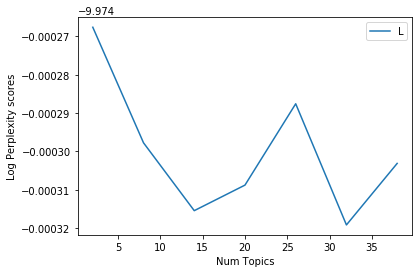

In [18]:
#log perplexity 시각화    
import matplotlib.pyplot as plt
x = range(start1, limit1, step1)
plt.plot(x, perplexity_scores)
plt.xlabel("Num Topics")
plt.ylabel("Log Perplexity scores")
plt.legend(("Log Perplexity"), loc='best')
plt.show()

log perplexity 수치 상으로 32가 가장 optimal하지만 분류 효율을 고려해서 토픽 수는 14로 정함

## 4. 모델링
- 토픽 수(NUM_TOPICS)와 토픽 키워드 수(NUM_TOPIC_WORDS)를 지정한다.
    - 1회 시행 시에는 임의로 지정하고, 후에 log perplexity 값을 계산하여 최적의 토픽 수로 재지정해준다.

In [41]:
#토픽 수와 토픽 키워드 수 지정
NUM_TOPICS = 14    #토픽 수
NUM_TOPIC_WORDS = 15    #토픽 키워드 수

#모델 시행
lda_model = models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS,
                        id2word=dictionary,
                        alpha='auto')

#실행할 때마다 결과가 달라짐; 원하는 결과가 나올 때까지

Topic ID: 0
	피해자	0.015441534109413624
	사건	0.013138161972165108
	처벌	0.0094000780954957
	피해	0.007628896739333868
	범죄	0.007297794800251722
	검사	0.00721129821613431
	경찰	0.0071966396644711494
	판결	0.007185733877122402
	판사	0.006372920703142881
	사실	0.006017421837896109
	증거	0.0059396387077867985
	억울	0.005761085543781519
	가해자	0.005680609494447708
	수사	0.005548290908336639
	검찰	0.005059225019067526


Topic ID: 1
	공무원	0.10108289867639542
	행정	0.07693599164485931
	일반	0.06333513557910919
	거짓말	0.013501394540071487
	운전	0.01301309559494257
	선출	0.012877949513494968
	직분	0.010691532865166664
	인간	0.00922224298119545
	전부	0.008943475782871246
	야합	0.007893666625022888
	전직	0.006646058987826109
	북한	0.006195159163326025
	신들	0.006003635469824076
	국회의원	0.005999664310365915
	조직	0.005153188481926918


Topic ID: 2
	북한	0.04466790705919266
	국제	0.02784888818860054
	미국	0.02169025130569935
	외교부	0.02053970843553543
	비핵화	0.010181687772274017
	한반도	0.009738323278725147
	중국	0.009054922498762608
	외교	0.008067596703767776
	사건	0.00804

In [37]:
#모델링 결과 몇개만 확인해보기
for i in range(10):
    print(article_indexes[i])
    topics_list = lda_model.get_document_topics(corpus[i])
    print(docs_filtered[i])
    print(topics_list)
    hi_topic, hi_prob = get_highest_topic(topics_list)
    print(hi_topic, hi_prob)
    
    print('\n')

0
['공공기관', '무조건', '정규직', '전환', '반대', '정규직', '일자리', '찬성', '공공기관', '비정규직', '인맥', '경우', '자질', '정규직', '피해', '공공기관', '정규직', '경쟁률', '경우', '노량진', '청춘', '공부', '기존', '비정규직', '무조건', '무기', '전환', '다른', '정유', '탄생', '역차별', '필요', '신규', '채용', '공채', '절차', '무기', '전환', '예전', '공무원', '능직', '일반', '전환', '초등학교', '중초', '교사', '임용', '실제', '업무', '처리', '미흡', '사립학교', '인건비', '주니', '사립학교', '공채', '부디', '사례', '하나', '하나', '처리', '전체', '정규직', '숫자', '전환', '실천', '역차별', '채용']
[(2, 0.8475936), (7, 0.13375847)]
2 0.8475936


1
['소액', '주주', '보호', '존경', '중국', '자원', '상장', '사의', '소액', '주주', '중국', '자원', '이하', '중원', '이번', '회계감사', '의견', '거절', '감사', '판단', '상장폐지', '목전', '상장폐지', '국내', '상장', '천문학', '금액', '취득', '회사', '규모', '개인', '자산', '자신', '분도', '이득', '중국인', '장화', '사장', '정리', '매매', '휴지', '조각', '비용', '자신', '다시', '로서', '지위', '다시', '획득', '자신', '기업', '피땀', '자금', '중국인', '사장', '금융', '당국', '상장', '운영', '주체', '거래소', '누구', '책임', '그냥', '국내', '소액', '주주', '눈물', '통속', '주식', '투자', '개인', '판단', '투자', '개인', '책임', '기전', '과정', '규정', '상식', '존경', '말씀', '가슴', 

## 5. 모델링 결과 시각화
- 토픽 모델링 결과를 인터렉티브 비주얼라이제이션 형태로 시각화한다.

In [ ]:
prepared_data = gensimvis.prepare(lda_model, corpus, dictionary)

#주피터에서 보기
pyLDAvis.display(prepared_data)

#HTML로 시각화 결과 저장
pyLDAvis.save_html(prepared_data, f'./LDA/{KEYWORD}_LDAvis.html')

## 6. 모델 저장
- 시각화로 확인한 결과, 분류 모델이 마음에 든다면 로컬에 저장한다.

In [44]:
#모델 저장
lda_model.save(f'./LDA/{KEYWORD}.lda')    #모델 불러올 때는 lda_model = models.ldamodel.LdaModel.load('모델명.lda')

#분류 결과 저장
print_topic_words(lda_model)